In [3]:
import cdsapi
from netCDF4 import Dataset
import numpy as np
import datetime
from calendar import monthrange
import matplotlib.pyplot as plt

# c = cdsapi.Client()

In [42]:
c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'format': 'netcdf',
        'product_type': 'monthly_averaged_reanalysis',
        'variable': [
            'sea_ice_cover', 'snowfall','2m_temperature',
        ],
        'year': [
            '2000',
            '2001', '2002', '2003',
            '2004', '2005', '2006',
            '2007', '2008', '2009',
            '2010', '2011', '2012',
            '2013', '2014', '2015',
            '2016', '2017', '2018',
            '2019', '2020', '2021','2022','2023',
        ],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'time': '00:00',
        'area': [
            -50, -180, -90,
            180,
        ],
    },
    'SH.nc')

2024-08-16 14:31:26,585 INFO Welcome to the CDS.
 As per our announcements on the Forum, this instance of CDS will soon be decommissioned.
 Please update your cdsapi package to a version >=0.7.0, create an account on CDS-Beta and update your .cdsapirc file. We strongly recommend users to check our Guidelines at https://confluence.ecmwf.int/x/uINmFw
 The current legacy system will be kept for a while, but we will reduce resources gradually until full decommissioning in September 2024.
2024-08-16 14:31:26,587 WARNING MOVE TO CDS-Beta
2024-08-16 14:31:26,588 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2024-08-16 14:31:26,719 INFO Request is queued
2024-08-16 14:41:46,994 INFO Request is running
2024-08-16 14:43:47,388 INFO Request is completed
2024-08-16 14:43:47,390 INFO Downloading https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data9/adaptor.mars.internal-1723812139.8461306-22605-3-006

Result(content_length=400628756,content_type=application/x-netcdf,location=https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data9/adaptor.mars.internal-1723812139.8461306-22605-3-0064bcfb-a1f2-42db-a829-3baaa7e899da.nc)

In [43]:
c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'format': 'netcdf',
        'product_type': 'monthly_averaged_reanalysis',
        'variable': [
            'sea_ice_cover', 'snowfall','2m_temperature',
        ],
        'year': [
            '2000',
            '2001', '2002', '2003',
            '2004', '2005', '2006',
            '2007', '2008', '2009',
            '2010', '2011', '2012',
            '2013', '2014', '2015',
            '2016', '2017', '2018',
            '2019', '2020', '2021','2022','2023',
        ],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'time': '00:00',
        'area': [
            50, -180, 90,
            180,
        ],
    },
    'NH.nc')

2024-08-16 14:44:49,718 INFO Welcome to the CDS.
 As per our announcements on the Forum, this instance of CDS will soon be decommissioned.
 Please update your cdsapi package to a version >=0.7.0, create an account on CDS-Beta and update your .cdsapirc file. We strongly recommend users to check our Guidelines at https://confluence.ecmwf.int/x/uINmFw
 The current legacy system will be kept for a while, but we will reduce resources gradually until full decommissioning in September 2024.
2024-08-16 14:44:49,719 WARNING MOVE TO CDS-Beta
2024-08-16 14:44:49,719 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2024-08-16 14:44:49,898 INFO Request is queued
2024-08-16 14:45:03,974 INFO Request is running
2024-08-16 14:46:45,037 INFO Request is completed
2024-08-16 14:46:45,039 INFO Downloading https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data4/adaptor.mars.internal-1723812378.8996089-27907-11-65

Result(content_length=400628756,content_type=application/x-netcdf,location=https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data4/adaptor.mars.internal-1723812378.8996089-27907-11-653b8c09-68c1-42e6-92fd-674d1e14c824.nc)

In [6]:
month_nums = np.arange(1,13)
output_dict = {}


for hem in ['SH','NH']:

    d = Dataset(f'../data/{hem[:2]}.nc')
    
    lat_grid = np.tile(np.array(d['latitude']),(d['longitude'].shape[0],1)).T

    lon_grid = np.tile(np.array(d['longitude']),(d['latitude'].shape[0],1))

    dt0 = datetime.date(1900,1,1)

    dts = [dt0 + datetime.timedelta(hours=int(d)) for d in d['time']]

    months = np.array([d.month for d in dts])

    years = np.array([d.year for d in dts])
    
    # Make a sea ice concentration mask where it's 0 if SIC<50% and 1 if >50%
    
    sic = np.array(d['siconc'])

    sic[sic<0.5] = np.nan

    sic[sic>0.5] = 1

    # https://apps.ecmwf.int/codes/grib/param-db/?id=144
    
    sf = np.array(d['sf']) #Snowfall in m per day
    sf[np.isnan(sic)] = np.nan
    
    at = np.array(d['t2m']) #Snowfall in m per day
    at[np.isnan(sic)] = np.nan
    
    
    ### Time to do the spatial averaging
    
    monthly_mean_sf = []
    monthly_mean_at = []
    
    for i in range(sf.shape[0]):
        sf_mon = sf[i][~np.isnan(sf[i])]
        weights_mon = lat_grid[~np.isnan(sf[i])]
        monthly_mean_sf.append(  np.average(sf_mon,weights=weights_mon) )
        
        
        at_mon = at[i][~np.isnan(at[i])]
        weights_mon = lat_grid[~np.isnan(at[i])]
        monthly_mean_at.append(  np.average(at_mon,weights=weights_mon) )
        
    monthly_mean_sf = np.array(monthly_mean_sf)
    monthly_mean_at = np.array(monthly_mean_at)
        
    cum_sf = []
    cum_at = []

    for year in years:
        
        month_lengths = np.array([monthrange(year,month)[1] for month in np.arange(1,13)])

        monthly_means_year = monthly_mean_sf[years==year]
        monthly_cumulative = np.multiply(monthly_means_year,month_lengths)
        cum_sf.append( monthly_cumulative)
        
        monthly_means_year = monthly_mean_at[years==year]
#         monthly_cumulative = np.multiply(monthly_means_year,month_lengths)
        cum_at.append( monthly_means_year)
    
    output_dict[hem] = {'sf':cum_sf,
                        'at':cum_at}
    
#     break

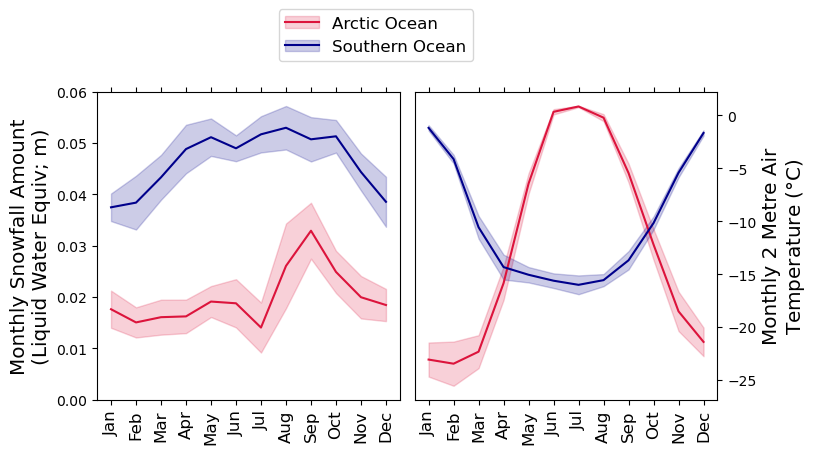

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))

var = 'at'

zeroC = 273.15

colors = {'NH':'crimson','SH':'darkblue'}
labels = {'NH':'Northern Hemsiphere','SH':'Southern Hemisphere'}

fill_alpha=0.2


for hem in ['NH','SH']:
    
    mean = np.mean(output_dict[hem]['sf'],axis=0)
    std = np.std(output_dict[hem]['sf'],axis=0)

#     ax1.errorbar(month_nums,mean,yerr=std,label=hem,color=colors[hem],capsize=3)
    ax1.fill_between(month_nums,mean-std,mean+std,color=colors[hem],alpha=fill_alpha)
    ax1.plot(month_nums,mean,label=labels[hem],color=colors[hem])
   
    
    ax1.set_ylim(0,0.06)
    ax1.set_ylabel('Monthly Snowfall Amount\n(Liquid Water Equiv; m)',fontsize='x-large')
    
l = []
for hem in ['NH','SH']:
    
    mean = np.mean(output_dict[hem][var],axis=0)-zeroC
    std = np.std(output_dict[hem][var],axis=0)

    f = ax2.fill_between(month_nums,mean-std,mean+std,color=colors[hem],alpha=fill_alpha)
    p = ax2.plot(month_nums,mean,label=labels[hem],color=colors[hem])
    
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Monthly 2 Metre Air\nTemperature ($\degree$C)',fontsize='x-large')
    ax2.yaxis.set_label_position('right')
    
    l.append((p[0],f))

mon_abbvs = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    
for ax in [ax1,ax2]:
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(mon_abbvs,rotation=90,fontsize='large')
    ax.tick_params('x',bottom=True,top=True)

ax2.legend(l, ['Arctic Ocean','Southern Ocean'],loc=(-0.45,1.1),fontsize='large')
fig.subplots_adjust(wspace=0.05)


fdir = '/home/robbie/Dropbox/ISSI/figures/'
plt.savefig(f'{fdir}/floe_weather.pdf',bbox_inches='tight')
fdir = '/home/robbie/Dropbox/Apps/Overleaf/ISSI_Perspective/figures/'
plt.savefig(f'{fdir}/floe_weather.pdf',bbox_inches='tight')